In [40]:
# usings

using Pkg; Pkg.activate(".")
using Dates
# using Regex
using Interpolations
using Statistics
using DSP
using Printf
using PyPlot

# general PSL DAS readers
include("./readers.jl")
using .NoaaDas
using .DasFps       # fast pressure sensor
using .ShipPosmv

# data = """5958832 r14.932;a73;q100
# 5959238 r15.297;a29;q87"""

  Activating project at `~/Projects/ASTRAL/mast`


In [41]:
# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

"recursively call f n times: f^n(x)"
recurse(f, x, n::Integer) = n==0 ? x : recurse(f, f(x), n-1)

anom(x) = x .- mean(x)

square(n) = collect(ones(n)/n)
"n-point running mean, run forwards, back, forwards, back"
runningmean4(x, n) = recurse(x->filtfilt(square(n),x), x, 2)
"highpass filter from the 4-pass running mean"
highpass4(x, n) = x .- runningmean4(x, n)

"despiking filter"
function despike(x, n=240, tol=2)
    y = runningmean4(x, n)
    v = runningmean4((x.-y).^2, n) # running variance
    # id spikes outside tol*std dev of running mean
    b = ( (x.-y).^2 .> tol^2 .* v )
    spikes = findall(b)
    good = findall(.!b)
    # interpolate over spikes, assuming gridded data
    itp = interpolate((good,), x[good], Gridded(Linear()))
    z = copy(x)
    z[spikes] .= NaN
    innerspikes = spikes[first(good) .< spikes .< last(good)] #can be reinterpolated
    z[innerspikes] .= itp[innerspikes]
    return z
end

# interpolator for DateTime coordinates
"convert DateTime to a Number (milliseconds) delta relative to offset"
itime(dt, offst=DateTime(2024,4,1)) = Dates.value(Millisecond(dt - offst))

"linear interpolation function with DateTime coordinate"
function interpit(dt::AbstractVector{DateTime}, x::AbstractVector{<:Number})
    itp_core = interpolate( (itime.(dt),), x, Gridded(Linear()) )
    itp(dt) = itp_core( itime(dt) )
    return itp
end

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end

"slope Dy / Dx of y(x)"
slope(y,x) = anom(x) \ anom(y)

"remove mean and detrend y(x)"
function detrend(y, x=1:length(x))
    m = slope(y,x)
    return anom(y) .- m.*anom(x), m
end

hp

In [42]:
dt = Date(2024,6,4)
Lsr = read_lsr_dict(get_das_pathfiles("lsr", dt))

Dict{Symbol, Any} with 4 entries:
  :R    => Float32[13.713, 13.723, 13.738, 13.743, 13.759, 0.131, 13.899, 13.91…
  :A    => Float32[70.0, 60.0, 39.0, 26.0, 27.0, 14.0, 67.0, 55.0, 57.0, 52.0  …
  :Q    => Float32[100.0, 100.0, 99.0, 65.0, 83.0, 69.0, 100.0, 100.0, 100.0, 9…
  :time => [DateTime("2024-06-04T00:00:00.028"), DateTime("2024-06-04T00:00:00.…

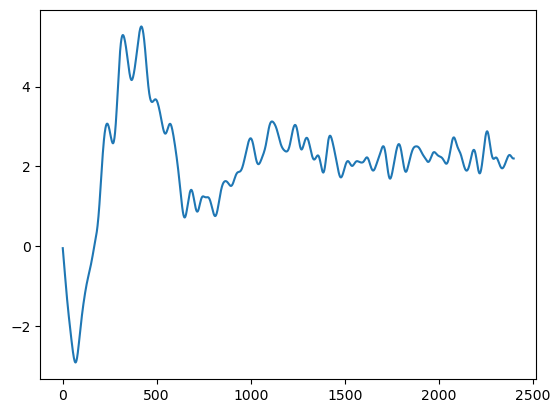

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x364bf5690>

In [50]:
# read motion file for heave
motkeys = [:time,
           :ratey, # (rad/s)      + bow down
           :ratex, # (rad/s)      + port up (broken for ASTRAL 2024 leg 1)
           :ratez, # (rad/s)      + bow to port
           :accy,  # (m.s^-^2)    + to port
           :accx,  # (m.s^-^2)    + forward
           :accz ] # (m.s^-^2)    + up"""))
Mot = read_das_dict(get_das_pathfiles("mot", dt), motkeys; ncolumn=length(motkeys)-1)

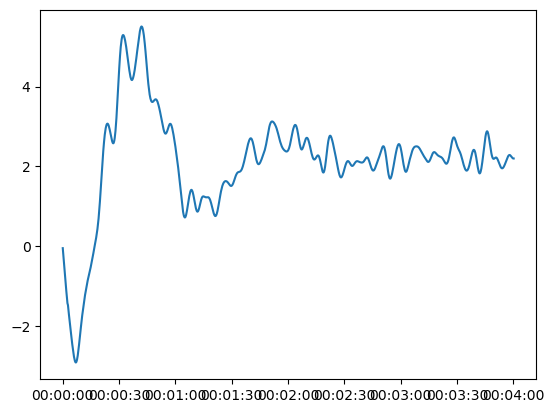

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x34cb1bc10>

In [55]:
heave = cumsum( hp(cumsum( hp(anom(Mot[:accz]), 1/800) ), 1/800) ) * 0.01
plot(Mot[:time][1:2400], heave[1:2400])

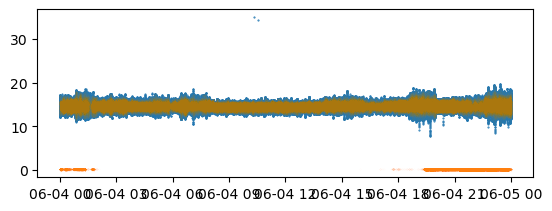

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3342bc970>

In [5]:
ii = (Lsr[:Q] .> 80) .& (Lsr[:R] .> sqrt.(Lsr[:A]))
clf(); subplot(2,1,1)
# plot(Lsr[:time][ii], Lsr[:Q][ii], linestyle="none", marker=".")
# plot(Lsr[:time][ii], Lsr[:A][ii], linestyle="none", marker=".", markersize=1)
ii = (Lsr[:R] .> 5.0) .& (Lsr[:Q] .> 50) .& (Lsr[:R] .> sqrt.(Lsr[:A]))
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
# ii = (Lsr[:R] .> sqrt.(Lsr[:A]))
# plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
ii = (Lsr[:Q] .>= 80)
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=.02)
# xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,30,30)])

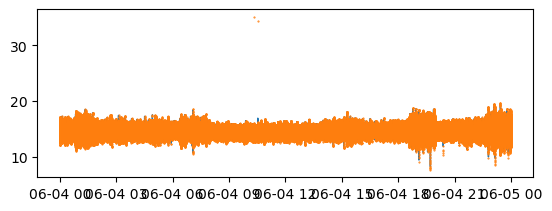

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3392dd630>

In [6]:
ii = (Lsr[:R] .> 5.0) .& (Lsr[:Q] .> 50)
itplsr = interpit(Lsr[:time][ii], Lsr[:R][ii])
cdt = DateTime(2024,6,4,0,5):Millisecond(500):DateTime(2024,6,4,23,59,55)
# take care not to get a BoundsError!
# ilsr = itplsr(cdt)

clf(); subplot(2,1,1)
plot(cdt, itplsr.(cdt), linewidth=1)
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
# xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
# 2 Hz, and interpolation look great

In [12]:
# read fast pressure
Fp0 = read_fps_dict(get_das_pathfiles("fps0", dt), [:time, :press]; ncolumn=1)
Fp2 = read_fps_dict(get_das_pathfiles("fps2", dt), [:time, :press]; ncolumn=1)

function filtsort(t, p)
    ii = @. isfinite(t) && !ismissing(t) && isfinite(p) && !ismissing(p) && (p < 10_000)
    sp = sortperm(t[ii])
    t[ii][sp], p[ii][sp]
end

(fp0t, fp0p) = filtsort(Fp0[:time], Fp0[:press])
(fp2t, fp2p) = filtsort(Fp2[:time], Fp2[:press])

([DateTime("2024-06-04T00:00:00.017"), DateTime("2024-06-04T00:00:00.126"), DateTime("2024-06-04T00:00:00.220"), DateTime("2024-06-04T00:00:00.329"), DateTime("2024-06-04T00:00:00.423"), DateTime("2024-06-04T00:00:00.516"), DateTime("2024-06-04T00:00:00.626"), DateTime("2024-06-04T00:00:00.719"), DateTime("2024-06-04T00:00:00.828"), DateTime("2024-06-04T00:00:00.922")  …  DateTime("2024-06-04T23:59:59.057"), DateTime("2024-06-04T23:59:59.151"), DateTime("2024-06-04T23:59:59.245"), DateTime("2024-06-04T23:59:59.354"), DateTime("2024-06-04T23:59:59.447"), DateTime("2024-06-04T23:59:59.557"), DateTime("2024-06-04T23:59:59.650"), DateTime("2024-06-04T23:59:59.744"), DateTime("2024-06-04T23:59:59.853"), DateTime("2024-06-04T23:59:59.947")], Union{Missing, Float32}[1005.89124f0, 1005.8752f0, 1005.8759f0, 1005.87067f0, 1005.8954f0, 1005.8916f0, 1005.9002f0, 1005.8983f0, 1005.90625f0, 1005.9063f0  …  1005.1044f0, 1005.10455f0, 1005.11145f0, 1005.09174f0, 1005.0897f0, 1005.11957f0, 1005.15027f0

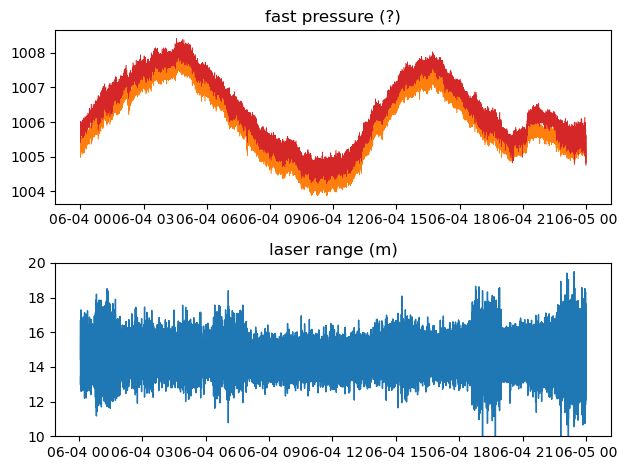

In [15]:

clf()
subplot(2,1,1)
plot(Fp0[:time][.!ii], Fp0[:press][.!ii], linewidth=0.4)
plot(Fp2[:time][.!ii], Fp2[:press][.!ii], linewidth=0.4)
# xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
# ylim([1998.5, 2000])
title("fast pressure (hPa)")

subplot(2,1,2)
plot(cdt, itplsr.(cdt), linewidth=1)
# xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
ylim([10, 20])
title("laser range (m)")

tight_layout()

In [39]:
mean(itplsr.(cdt))

LoadError: UndefVarError: `mean` not defined